<a href="https://colab.research.google.com/github/paolaserra/Algorithms-for-massive-datasets/blob/main/AMD_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Market Basket analysis using Old newspapers dataset**

Paola Serra ID 960547 Giulia Hadjiandrea ID 941780

In [ ]:
!lscpu 

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           AuthenticAMD
CPU family:          23
Model:               49
Model name:          AMD EPYC 7B12
Stepping:            0
CPU MHz:             2249.998
BogoMIPS:            4499.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            512K
L3 cache:            16384K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a misalignss

### **Access Kaggle API, download the "Old Newspapers" dataset and unzip it**

In [ ]:
# upload token file kaggle.json

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"giuliahadjiandrea","key":"fc0ce37d8f89c0421a66fda0695b7b94"}'}

In [ ]:
# move the token file to the ./kaggle directory
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle 
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
# authenticate to the Kaggle API
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [ ]:
# download and unzip "Old Newspapers" dataset

!kaggle datasets download -d alvations/old-newspapers

100% 2.05G/2.05G [00:31<00:00, 77.2MB/s]
100% 2.05G/2.05G [00:31<00:00, 69.3MB/s]


In [ ]:
!unzip old-newspapers.zip

Archive:  old-newspapers.zip
  inflating: old-newspaper.tsv       


### **Initialize a SparkContext object**


In [ ]:
# initialize a SparkContext object 

! pip install pyspark
import pyspark
sc = pyspark.SparkContext()

     |████████████████████████████████| 281.4 MB 42 kB/s 
     |████████████████████████████████| 198 kB 67.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=47bd5048a68577f18f108d34d6dc95397fac5749d5cf5ef77e2d750ad0868598
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
#install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null  


In [ ]:
# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop3.2.tgz


In [ ]:
# unzip the spark file to the current folder
!tar xf spark-3.0.2-bin-hadoop3.2.tgz

#install findspark
!pip install -q findspark

In [ ]:
# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init("spark-3.0.2-bin-hadoop3.2")  #SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

**PREPROCESSING**

Content
The columns of each row in the .tsv file are:

Langauge: Language of the text.

Source: Newspaper from which the text is from.

Date: Date of the article that contains the text.

Text: Sentence/paragraph from the newspaper


In [ ]:
#DATASET to DF
import pandas
df = spark.read.csv("/content/old-newspaper.tsv", sep=r'\t', header=True)

In [ ]:
df.head(1)

[Row(Language='Afrikaans', Source='republikein.com.na', Date='2011/09/14', Text='Die veranderinge aan die Britsgeboude Avensis sluit in hersiene stilering aan die buitekant, wat n voorkantontwerp ingevolge Toyota se nuwe ontwerpstyl insluit.')]

In [ ]:
english = df[df.Language == 'English']

In [ ]:
english.show()

+--------+------------------+----------+--------------------+
|Language|            Source|      Date|                Text|
+--------+------------------+----------+--------------------+
| English|       latimes.com|2012/04/29|He wasn't home al...|
| English|      stltoday.com|2011/07/10|The St. Louis pla...|
| English|         freep.com|2012/05/07|WSU's plans quick...|
| English|            nj.com|2011/02/05|The Alaimo Group ...|
| English|        sacbee.com|2011/10/02|And when it's oft...|
| English|     cleveland.com|2012/04/27|There was a certa...|
| English|         freep.com|2012/05/03|14915 Charlevoix,...|
| English|            nj.com|2011/02/02|"""It’s just anot...|
| English|chicagotribune.com|2012/01/05|But time and agai...|
| English|      indystar.com|2012/05/04|I was just trying...|
| English|   startribune.com|2012/04/25|MHTA President an...|
| English|           ajc.com|2012/05/04|"""The absurdity ...|
| English|     cleveland.com|2009/05/29|"GM labor relatio...|
| Englis

In [ ]:
# create an RDD from the "Old Newspapers" dataset and display the first instance. 
#Resilient Distributed Datasets (RDD) is the fundamental data structure of Spark. RDDs are immutable and fault tolerant in nature. 
#These are distributed collections of objects. The datasets are divided into a logical partition, which is further computed on different nodes over the cluster. 
#Thus, RDD is just the way of representing dataset distributed across multiple machines, which can be operated around in parallel.
# RDDs are called resilient because they have the ability to always re-compute an RDD. 

newsRDD = sc.textFile("old-newspaper.tsv", 2)
newsRDD.take(1)

['Language\tSource\tDate\tText']

In [ ]:
def split_row(x):

  tup = x.split('''\t''')
  
  date = tup[2]
  year = date[:4]  

  return (tup[0], year, tup[3])

In [ ]:
subRDD = newsRDD.map(split_row)
subRDD.take(1)

[('Language', 'Date', 'Text')]

In [ ]:
# count by years

subRDD.map(lambda r: r[1]).countByValue()

defaultdict(int,
            {'1970': 6,
             '2000': 6075,
             '2001': 7811,
             '2002': 6183,
             '2003': 8452,
             '2004': 20091,
             '2005': 77733,
             '2006': 169678,
             '2007': 369179,
             '2008': 687741,
             '2009': 1494895,
             '2010': 3207680,
             '2011': 7247763,
             '2012': 2812367,
             '2013': 380469,
             'Date': 1,
             'UNKN': 309918})

In [ ]:

subRDD.map(lambda r: r[0]).countByValue()

defaultdict(int,
            {'Afrikaans': 152312,
             'Albanian': 228553,
             'Amharic': 32553,
             'Arabic': 202461,
             'Armenian': 156586,
             'Azerbaijan': 140995,
             'Bengali': 58998,
             'Bosnian': 181370,
             'Catalan': 81893,
             'Chinese (Simplified)': 682472,
             'Chinese (Traditional)': 333735,
             'Croatian': 227317,
             'Czech': 276881,
             'Danish': 887016,
             'Dutch': 232176,
             'English': 1010242,
             'Farsi': 306846,
             'Finnish': 485758,
             'French': 358001,
             'Galician': 227073,
             'Georgian': 164614,
             'German': 244743,
             'Greek': 230405,
             'Hebrew': 199047,
             'Hindi': 115445,
             'Hungarian': 245685,
             'Icelandic': 39093,
             'Indonesian': 781521,
             'Italian': 169630,
             'Japanese': 3129

In [ ]:
# look directly at those with year = 'Date' or year = '1970'

subRDD.filter(lambda r: r[1]=='Date' or r[1]=='1970').collect()

[('Language', 'Date', 'Text'),
 ('French',
  '1970',
  "Habitué depuis deux ans à faire venir des attaquants au mercato hivernal (Quercia en 2008 et Birsa en 2009), Jean Fernandez justifie les arrivées de Jo-Gook et Fall comme des choix « d'avenir ». Et éclaire sur la capacité de ces joueurs à réussir à court terme. « L'expérience me fait dire qu'il y a plus d'échecs que de réussite au mercato d'hiver. Lorsque j'étais à Marseille, Maoulida et Pagis avaient été de bonnes recrues »."),
 ('French',
  '1970',
  "Deux joueurs qui n'ont rien coûté, ou presque, à l'AJA fidèle à sa stratégie de recruter malin. Jo-Gook, auteur d'une apparition en Coupe de France et une en Ligue 1, a confirmé que « le Patriot », comme il est surnommé en Corée du Sud, aura besoin de quelques mois d'adaptation."),
 ('French',
  '1970',
  "Ce que l'on sait, d'ores-et-déjà, c'est que Jelen (en fin de contrat en juin) a peu de chances d'en faire partie. La tendance de l'hiver ne sera peut-être pas celle de l'été, cer

In [ ]:
# look at the language in which the ones with unknown date were written

subRDD.filter(lambda r: r[1]=='UNKN').map(lambda r: r[0]).countByValue()  # all in Spanish

defaultdict(int, {'Spanish': 309918})

In [ ]:
textFrench = subRDD.filter(lambda x: x[0]=='French').map(lambda r: r[0]).countByValue()

In [ ]:
textFrench

defaultdict(int, {'French': 358001})

In [ ]:
textRDD_Eng = subRDD.filter(lambda x: x[0]=='English')
textRDD_Eng.take(5)

[('English', '2012', "He wasn't home alone, apparently."),
 ('English',
  '2011',
  'The St. Louis plant had to close. It would die of old age. Workers had been making cars there since the onset of mass automotive production in the 1920s.'),
 ('English',
  '2012',
  "WSU's plans quickly became a hot topic on local online sites. Though most people applauded plans for the new biomedical center, many deplored the potential loss of the building."),
 ('English',
  '2011',
  'The Alaimo Group of Mount Holly was up for a contract last fall to evaluate and suggest improvements to Trenton Water Works. But campaign finance records released this week show the two employees donated a total of $4,500 to the political action committee (PAC) Partners for Progress in early June. Partners for Progress reported it gave more than $10,000 in both direct and in-kind contributions to Mayor Tony Mack in the two weeks leading up to his victory in the mayoral runoff election June 15.'),
 ('English',
  '2011',


In [ ]:
textRDD_Eng = textRDD_Eng.sample(withReplacement = False, fraction = 0.1, seed = 1995).repartition(2)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import re

from nltk.corpus import stopwords

from numpy import unique
from string import punctuation

def preprocess(row):

  ### ARGS
  # row = (language, date, text)

  ### OUTPUT
  # list of lemmatized tokens in the text field

  ### REQUIRES
  # libraries: nltk, re, numpy.unique, string.punctuation
  # modules (nltk): stopwords, punkt, wordnet 

  if row[0] == 'English':
    sw = stopwords.words("english") + list(punctuation) + ["n't", "'m", "'d", "'re", "'s","'ve", "'ll", '``', "''", "--", '“', '’','”','...',"«", "»", "–"]

  text = re.sub(r'[^a-zA-z.,!?/:;\"\'\s]', '', row[2])

  lemmatizer = nltk.WordNetLemmatizer()
  tokenized_text = nltk.word_tokenize(text.lower())
  tokenized_text = list(unique(tokenized_text))

  return [lemmatizer.lemmatize(w) for w in tokenized_text if w not in sw]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#execute 2 times
text_tokenized = textRDD_Eng.map(preprocess)
text_tokenized.take(5)

[['charged',
  'controlled',
  'dangerous',
  'gattone',
  'paraphernalia',
  'possession',
  'substance'],
 ['alex',
  'among',
  'barret',
  'behind',
  'blue',
  'come',
  'credit',
  'defense',
  'defensemen',
  'deserves',
  'enough',
  'gaudy',
  'goalie',
  'good',
  'jackman',
  'kevin',
  'league',
  'much',
  'net',
  'outstanding',
  'petro',
  'pietrangelo',
  'played',
  'plus',
  'point',
  'produce',
  'protect',
  'rank',
  'rank',
  'right',
  'season',
  'shattenkirk',
  'shatty',
  'stats',
  'th',
  'three',
  'top'],
 ['admittedly',
  'athletic',
  'basketball',
  'basketball',
  'beckoned',
  'behind',
  'bob',
  'bowie',
  'business',
  'coach',
  'collegeage',
  'comedian',
  'continued',
  'court',
  'daughter',
  'day',
  'director',
  'existence',
  'experience',
  'filed',
  'general',
  'glistening',
  'guard/standup',
  'halfdozen',
  'hardwood',
  'help',
  'hoop',
  'hosley',
  'john',
  'looked',
  'man',
  'manager',
  'middleschool',
  'mile',
  'much

In [ ]:
textRDD_Eng.take(5), text_tokenized.take(5)

([('English',
   '2010',
   'Gattone was charged with possession of a controlled dangerous substance and possession of paraphernalia.'),
  ('English',
   '2012',
   "Then comes the defense, which has played outstanding all season and deserves much credit for those gaudy goalie stats. And not only do they protect the net, they produce. Kevin Shattenkirk's 23 points ranks 18th in the league among defensemen and Alex Pietrangelo comes in right behind him with 21 points, good enough for 26th among defensemen. And with Shatty (plus-17), Petro (+14) and Barret Jackman (+13), the Blues have three defensemen who rank in the top"),
  ('English',
   '2012',
   'The glistening court beckoned. As Bowie filed onto the hardwood behind 26-year-old guard/stand-up comedian Terry Hosley, general manager John Wolfe — a man with admittedly no basketball experience — looked on from the sideline. Coach Bob Topp, who spent much of the day working 15 miles down the road as a middle-school athletic director, r

(0.0, 120.0)

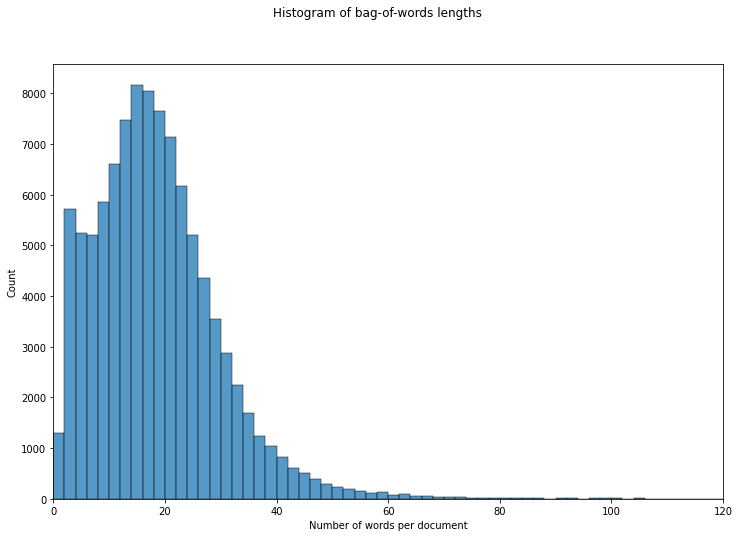

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
lengths = text_tokenized.map(len) \
                       .collect()

f, ax = plt.subplots(figsize = (12,8))
sns.histplot(data = lengths, binwidth = 2, ax = ax)
ax.set_xlabel("Number of words per document")
f.suptitle("Histogram of bag-of-words lengths")
plt.xlim([0, 120])

In [ ]:
text_tokenized.map(len).countByValue()

defaultdict(int,
            {0: 156,
             1: 1141,
             2: 2998,
             3: 2717,
             4: 2653,
             5: 2588,
             6: 2541,
             7: 2672,
             8: 2778,
             9: 3073,
             10: 3216,
             11: 3389,
             12: 3719,
             13: 3765,
             14: 3991,
             15: 4183,
             16: 4048,
             17: 4006,
             18: 3938,
             19: 3713,
             20: 3652,
             21: 3495,
             22: 3198,
             23: 2974,
             24: 2677,
             25: 2537,
             26: 2301,
             27: 2051,
             28: 1864,
             29: 1690,
             30: 1536,
             31: 1335,
             32: 1207,
             33: 1031,
             34: 908,
             35: 784,
             36: 671,
             37: 574,
             38: 564,
             39: 481,
             40: 458,
             41: 368,
             42: 326,
             4

## **A-Priori Algorithm**

In [ ]:
# SINGLETONS
# define function to iteratively sum counters of equal words

def sumcum(x,y):
  return x+y

In [ ]:
import itertools

**threshold = 0.01**

In [ ]:
threshold = 0.01

In [ ]:
N = textRDD_Eng.count()
N

100833

In [ ]:
#eng counters

freq_items = text_tokenized.flatMap(lambda bow: [(word, 1) for word in bow]) \
                                 .reduceByKey(sumcum) \
                                 .filter(lambda t: t[1] >= threshold*N) \
                                 .collect()

In [ ]:
freq_items

[('good', 2828),
 ('point', 2315),
 ('right', 2399),
 ('three', 3153),
 ('business', 1845),
 ('help', 1913),
 ('john', 1187),
 ('road', 1254),
 ('yearold', 1110),
 ('last', 4887),
 ('week', 2948),
 ('year', 9820),
 ('line', 1336),
 ('jersey', 1085),
 ('never', 1555),
 ('said', 23068),
 ('support', 1049),
 ('around', 1923),
 ('know', 2538),
 ('new', 6338),
 ('two', 5207),
 ('give', 1339),
 ('home', 3178),
 ('house', 1843),
 ('would', 6356),
 ('though', 1270),
 ('use', 1367),
 ('long', 1652),
 ('water', 1019),
 ('work', 2946),
 ('call', 1682),
 ('month', 2431),
 ('think', 2458),
 ('something', 1430),
 ('came', 1461),
 ('country', 1434),
 ('friday', 1378),
 ('high', 1966),
 ('like', 4579),
 ('plan', 1936),
 ('take', 2933),
 ('got', 1895),
 ('may', 2626),
 ('told', 1865),
 ('community', 1414),
 ('university', 1485),
 ('away', 1234),
 ('even', 2884),
 ('job', 2117),
 ('move', 1053),
 ('record', 1250),
 ('story', 1113),
 ('project', 1197),
 ('department', 1385),
 ('team', 3370),
 ('way', 309

In [ ]:
len(freq_items)

244

In [ ]:
#eng singletons
freq_singletons = list(map(lambda x: x[0], freq_items))

In [ ]:
freq_singletons

['good',
 'point',
 'right',
 'three',
 'business',
 'help',
 'john',
 'road',
 'yearold',
 'last',
 'week',
 'year',
 'line',
 'jersey',
 'never',
 'said',
 'support',
 'around',
 'know',
 'new',
 'two',
 'give',
 'home',
 'house',
 'would',
 'though',
 'use',
 'long',
 'water',
 'work',
 'call',
 'month',
 'think',
 'something',
 'came',
 'country',
 'friday',
 'high',
 'like',
 'plan',
 'take',
 'got',
 'may',
 'told',
 'community',
 'university',
 'away',
 'even',
 'job',
 'move',
 'record',
 'story',
 'project',
 'department',
 'team',
 'way',
 'area',
 'cleveland',
 'world',
 'feel',
 'april',
 'st.',
 'really',
 'say',
 'end',
 'start',
 'monday',
 'room',
 'group',
 'officer',
 'set',
 'state',
 'free',
 'public',
 'four',
 'official',
 'school',
 'make',
 'event',
 'pay',
 'service',
 'night',
 'thursday',
 'tax',
 'go',
 'run',
 'head',
 'took',
 'college',
 'best',
 'past',
 'always',
 'making',
 'third',
 'deal',
 'money',
 'already',
 'change',
 'several',
 'child',
 'stud

In [ ]:
counters_1perc = []
counters_1perc.append(len(freq_singletons))


In [ ]:
counters_1perc

[244]

In [ ]:
candidates = list(itertools.combinations(freq_singletons, 2))
candidates

[('good', 'point'),
 ('good', 'right'),
 ('good', 'three'),
 ('good', 'business'),
 ('good', 'help'),
 ('good', 'john'),
 ('good', 'road'),
 ('good', 'yearold'),
 ('good', 'last'),
 ('good', 'week'),
 ('good', 'year'),
 ('good', 'line'),
 ('good', 'jersey'),
 ('good', 'never'),
 ('good', 'said'),
 ('good', 'support'),
 ('good', 'around'),
 ('good', 'know'),
 ('good', 'new'),
 ('good', 'two'),
 ('good', 'give'),
 ('good', 'home'),
 ('good', 'house'),
 ('good', 'would'),
 ('good', 'though'),
 ('good', 'use'),
 ('good', 'long'),
 ('good', 'water'),
 ('good', 'work'),
 ('good', 'call'),
 ('good', 'month'),
 ('good', 'think'),
 ('good', 'something'),
 ('good', 'came'),
 ('good', 'country'),
 ('good', 'friday'),
 ('good', 'high'),
 ('good', 'like'),
 ('good', 'plan'),
 ('good', 'take'),
 ('good', 'got'),
 ('good', 'may'),
 ('good', 'told'),
 ('good', 'community'),
 ('good', 'university'),
 ('good', 'away'),
 ('good', 'even'),
 ('good', 'job'),
 ('good', 'move'),
 ('good', 'record'),
 ('good'

In [ ]:
candidates = list(map(set, candidates))
candidates   #to delete duplicates

[{'good', 'point'},
 {'good', 'right'},
 {'good', 'three'},
 {'business', 'good'},
 {'good', 'help'},
 {'good', 'john'},
 {'good', 'road'},
 {'good', 'yearold'},
 {'good', 'last'},
 {'good', 'week'},
 {'good', 'year'},
 {'good', 'line'},
 {'good', 'jersey'},
 {'good', 'never'},
 {'good', 'said'},
 {'good', 'support'},
 {'around', 'good'},
 {'good', 'know'},
 {'good', 'new'},
 {'good', 'two'},
 {'give', 'good'},
 {'good', 'home'},
 {'good', 'house'},
 {'good', 'would'},
 {'good', 'though'},
 {'good', 'use'},
 {'good', 'long'},
 {'good', 'water'},
 {'good', 'work'},
 {'call', 'good'},
 {'good', 'month'},
 {'good', 'think'},
 {'good', 'something'},
 {'came', 'good'},
 {'country', 'good'},
 {'friday', 'good'},
 {'good', 'high'},
 {'good', 'like'},
 {'good', 'plan'},
 {'good', 'take'},
 {'good', 'got'},
 {'good', 'may'},
 {'good', 'told'},
 {'community', 'good'},
 {'good', 'university'},
 {'away', 'good'},
 {'even', 'good'},
 {'good', 'job'},
 {'good', 'move'},
 {'good', 'record'},
 {'good'

In [ ]:
len(candidates)

29646

In [ ]:
### FIND CANDIDATE ITEMSETS 

def candidate_combinations(bow, candidates):

  return [(tuple(c), 1) for c in candidates if c.issubset(set(bow))]

In [ ]:
#eng frequent pairs - it takes 35min for running
new_freq_itemsets = text_tokenized.flatMap(lambda bow: candidate_combinations(bow, candidates)) \
                       .reduceByKey(sumcum) \
                       .filter(lambda t: t[1] >= threshold*N) \
                       .collect()

In [ ]:
new_freq_itemsets

[(('year', 'last'), 1895),
 (('said', 'know'), 1064),
 (('said', 'new'), 1305),
 (('two', 'said'), 1010),
 (('would', 'said'), 2220),
 (('said', 'think'), 1234),
 (('like', 'said'), 1449),
 (('year', 'said'), 2073),
 (('good', 'said'), 1015),
 (('said', 'last'), 1044),
 (('state', 'said'), 1348),
 (('said', 'make'), 1060),
 (('york', 'new'), 1113),
 (('said', 'get'), 1556),
 (('said', 'people'), 1673),
 (('said', 'time'), 1603),
 (('said', 'going'), 1405),
 (('said', 'could'), 1289),
 (('said', 'want'), 1071),
 (('said', 'also'), 1096),
 (('said', 'one'), 1845),
 (('year', 'one'), 1033)]

In [ ]:
#eng pairs with counters
old_freq_itemsets = list(map(lambda x: x[0], new_freq_itemsets))

In [ ]:
len(old_freq_itemsets)

22

In [ ]:
#length frequent eng pairs
counters_1perc.append(len(old_freq_itemsets))

In [ ]:
### FIND CANDIDATE ITEMSETS OF CARDINALITY K GIVEN FREQUENT ITEMSETS OF CARDINALITY K-1, FOR K > 2
# we don't need all combinations of elements of frequent itemsets,
# but itemsets whose immediate subsets are ALL frequent
# the next function is to be used for K > 2, whereas for K = 2 we may simply use itertools.combinations()

def find_candidate_itemsets(old_freq_itemsets, K):

  ### ARGS
  # old_freq_itemsets --> list of itemsets that were found to be frequent in previous pass
  # K --> cardinality of new candidate itemsets

  ### OUTPUT
  # list of candidate itemsets, as sets

  ### REQUIRES
  # libraries: itertools

  candidates = []

  for comb in list(itertools.combinations(old_freq_itemsets, K)):               
    cand = set().union(comb)                                                   
    if len(cand) == K:
      candidates.append(cand)                                                   #  let the union be a candidate itemset if its cardinality is K

  return candidates                                                             # returns list of sets

In [ ]:
candidates = find_candidate_itemsets(old_freq_itemsets, K = 3)
new_freq_itemsets3 = text_tokenized.flatMap(lambda bow: candidate_combinations(bow, candidates)) \
                       .reduceByKey(sumcum) \
                       .filter(lambda t: t[1] >= threshold*N) \
                       .collect()

In [ ]:
len(new_freq_itemsets3)

0

In [ ]:
len(old_freq_itemsets)

22

In [ ]:
counters_1perc

[244, 22]

**Threshold = 0.0075**

In [ ]:
threshold = 0.0075

In [ ]:
# sum all counters to obtain singleton counts

freq_items = text_tokenized.flatMap(lambda bow: [(word, 1) for word in bow]) \
                                 .reduceByKey(sumcum) \
                                 .filter(lambda t: t[1] >= threshold*N) \
                                 .collect()

In [ ]:
len(freq_items)
freq_items

[('good', 2828),
 ('league', 873),
 ('played', 936),
 ('point', 2315),
 ('right', 2399),
 ('three', 3153),
 ('business', 1845),
 ('help', 1913),
 ('john', 1187),
 ('manager', 818),
 ('road', 1254),
 ('working', 1000),
 ('yearold', 1110),
 ('portland', 804),
 ('last', 4887),
 ('week', 2948),
 ('year', 9820),
 ('fire', 760),
 ('line', 1336),
 ('power', 952),
 ('jersey', 1085),
 ('never', 1555),
 ('said', 23068),
 ('support', 1049),
 ('include', 771),
 ('leader', 943),
 ('around', 1923),
 ('idea', 780),
 ('know', 2538),
 ('meeting', 904),
 ('new', 6338),
 ('political', 798),
 ('two', 5207),
 ('authority', 810),
 ('charge', 903),
 ('give', 1339),
 ('home', 3178),
 ('house', 1843),
 ('would', 6356),
 ('though', 1270),
 ('use', 1367),
 ('become', 860),
 ('long', 1652),
 ('trying', 961),
 ('water', 1019),
 ('work', 2946),
 ('call', 1682),
 ('month', 2431),
 ('senior', 827),
 ('kind', 964),
 ('loss', 815),
 ('lost', 919),
 ('think', 2458),
 ('something', 1430),
 ('chance', 804),
 ('race', 777)

In [ ]:
# filters the counters exceeding the threshold

freq_singletons2 = list(map(lambda x: x[0], freq_items))

In [ ]:
len(freq_items)

381

In [ ]:
#computing the length of frequent singletons in english

counters_075perc = []

counters_075perc.append(len(freq_singletons2))

In [ ]:
candidates = list(itertools.combinations(freq_singletons2, 2))
len(candidates)

72390

In [ ]:
def candidate_combinations(bow, candidates):

  return [(tuple(c), 1) for c in candidates if c.issubset(set(bow))]

In [ ]:
#with 0.005 it takes 3h and a half,let's try with 0.075  1h and 43 min
new_freq_itemsets2 = text_tokenized.flatMap(lambda bow: candidate_combinations(bow, candidates)) \
                       .reduceByKey(sumcum) \
                       .filter(lambda t: t[1] >= threshold*N) \
                       .collect()

In [ ]:
old_freq_itemsets2 = list(map(lambda x: x[0], new_freq_itemsets2))

In [ ]:
counters_075perc.append(len(old_freq_itemsets2))

In [ ]:
old_freq_itemsets2

[('last', 'week'),
 ('year', 'last'),
 ('said', 'know'),
 ('new', 'jersey'),
 ('said', 'new'),
 ('two', 'said'),
 ('would', 'said'),
 ('work', 'said'),
 ('said', 'think'),
 ('year', 'new'),
 ('like', 'said'),
 ('said', 'team'),
 ('said', 'way'),
 ('year', 'said'),
 ('good', 'said'),
 ('said', 'last'),
 ('state', 'said'),
 ('said', 'make'),
 ('time', 'one'),
 ('year', 'state'),
 ('school', 'high'),
 ('york', 'new'),
 ('would', 'year'),
 ('ago', 'year'),
 ('two', 'year'),
 ('said', 'right'),
 ('said', 'go'),
 ('really', 'said'),
 ('school', 'said'),
 ('year', 'first'),
 ('year', 'time'),
 ('said', 'get'),
 ('said', 'see'),
 ('said', 'people'),
 ('said', 'city'),
 ('said', 'police'),
 ('said', 'day'),
 ('said', 'company'),
 ('said', 'time'),
 ('said', 'going'),
 ('need', 'said'),
 ('said', 'could'),
 ('lot', 'said'),
 ('thing', 'said'),
 ('said', 'want'),
 ('said', 'u'),
 ('said', 'game'),
 ('said', 'also'),
 ('said', 'first'),
 ('said', 'one'),
 ('year', 'one'),
 ('two', 'one'),
 ('said'

In [ ]:
len(old_freq_itemsets2)

55

In [ ]:
candidates = find_candidate_itemsets(old_freq_itemsets2, K = 3) 
new_freq_itemsets3 = text_tokenized.flatMap(lambda bow: candidate_combinations(bow, candidates)) \
                       .reduceByKey(sumcum) \
                       .filter(lambda t: t[1] >= threshold*N) \
                       .collect()

In [ ]:
len(new_freq_itemsets3)

0

In [ ]:
counters_075perc


[381, 55]

Which are the frequent singletons, weighted by their frequency?

In [ ]:
#importing the libraries for depicting the wordcloud

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
#defining a function for converting lists into strings

def convert_list_to_string(org_list, seperator=' '):
    """ Convert list to string, by joining all item in list with given separator.
        Returns the concatenated string """
    return seperator.join(org_list)

In [ ]:
#converting the list of freq_singletons in strings

string = convert_list_to_string(freq_singletons)

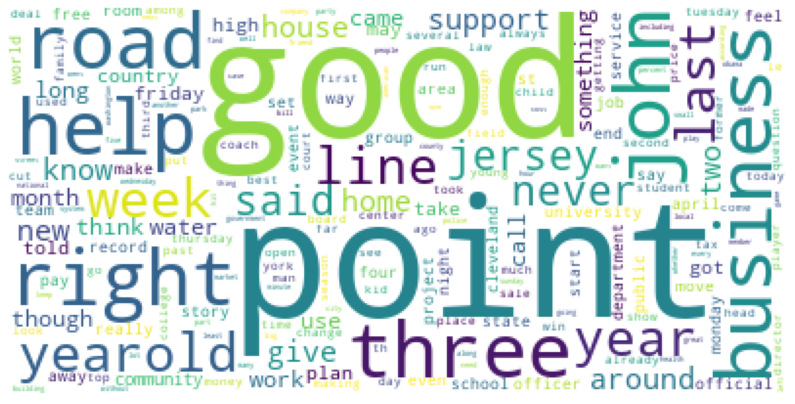

In [ ]:
#defining the worldcloud

wordcloud = WordCloud(background_color = "white").generate(string)

# displaying the wordcloud

plt.figure(figsize = (14, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

# it might be different each time due to sampling

**Threshold = 0.006**

In [ ]:
threshold = 0.006

In [ ]:
freq_items = text_tokenized.flatMap(lambda bow: [(word, 1) for word in bow]) \
                                 .reduceByKey(sumcum) \
                                 .filter(lambda t: t[1] >= threshold*N) \
                                 .collect()

In [ ]:
len(freq_items)

521

In [ ]:
freq_singletons3 = list(map(lambda x: x[0], freq_items))

In [ ]:
counters_06perc = []

counters_06perc.append(len(freq_singletons3))

In [ ]:
candidates = list(itertools.combinations(freq_singletons3, 2))
len(candidates)

135460

In [ ]:
candidates = list(map(set, candidates))

In [ ]:
candidates

[{'good', 'league'},
 {'good', 'played'},
 {'good', 'point'},
 {'good', 'right'},
 {'good', 'three'},
 {'business', 'good'},
 {'good', 'help'},
 {'good', 'john'},
 {'good', 'manager'},
 {'good', 'mile'},
 {'good', 'road'},
 {'good', 'working'},
 {'good', 'yearold'},
 {'good', 'portland'},
 {'america', 'good'},
 {'good', 'last'},
 {'good', 'week'},
 {'good', 'year'},
 {'fire', 'good'},
 {'good', 'line'},
 {'good', 'power'},
 {'good', 'jersey'},
 {'good', 'never'},
 {'good', 'said'},
 {'good', 'support'},
 {'good', 'include'},
 {'good', 'leader'},
 {'good', 'mark'},
 {'good', 'step'},
 {'around', 'good'},
 {'good', 'idea'},
 {'good', 'know'},
 {'good', 'meeting'},
 {'good', 'new'},
 {'good', 'political'},
 {'good', 'two'},
 {'authority', 'good'},
 {'charge', 'good'},
 {'good', 'spokesman'},
 {'give', 'good'},
 {'good', 'home'},
 {'good', 'house'},
 {'good', 'would'},
 {'good', 'though'},
 {'good', 'use'},
 {'become', 'good'},
 {'good', 'long'},
 {'good', 'trying'},
 {'good', 'water'},
 {

In [ ]:
new_freq_itemsets5 = text_tokenized.flatMap(lambda bow: candidate_combinations(bow, candidates)) \
                       .reduceByKey(sumcum) \
                       .filter(lambda t: t[1] >= threshold*N) \
                       .collect()

In [ ]:
old_freq_itemsets5 = list(map(lambda x: x[0], new_freq_itemsets5))

In [ ]:
#length frequent eng pairs
counters_06perc.append(len(old_freq_itemsets5))

In [ ]:
candidates = find_candidate_itemsets(old_freq_itemsets5, K = 3)
new_freq_itemsets6 = text_tokenized.flatMap(lambda bow: candidate_combinations(bow, candidates)) \
                       .reduceByKey(sumcum) \
                       .filter(lambda t: t[1] >= threshold*N) \
                       .collect()

In [ ]:
len(new_freq_itemsets6)

0

In [ ]:
new_freq_itemsets6

[]

In [ ]:
old_freq_itemsets6 = list(map(lambda x: x[0], new_freq_itemsets6))

In [ ]:
counters_06perc.append(len(old_freq_itemsets6))

**Plot of counters of frequent itemsets**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
counters_per_threshold = [counters_06perc,counters_075perc,counters_1perc]

counters_per_threshold = pd.DataFrame(counters_per_threshold)
counters_per_threshold.columns = ['1','2','3']
counters_per_threshold['thresholds'] = [0.006, 0.0075,0.01]
df = pd.melt(counters_per_threshold, id_vars="thresholds", var_name="cardinality", value_name="numbers")

In [ ]:
counters_1perc

In [ ]:
counters_1perc.remove(0)

In [ ]:
counters_1perc

Text(0.5, 0.98, 'Counts of frequent itemsets per threshold')

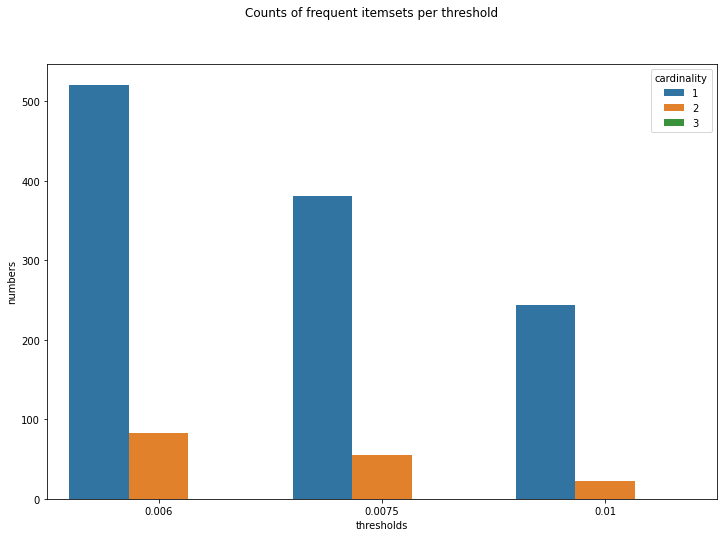

In [ ]:
f, ax = plt.subplots(figsize = (12,8))
sns.barplot(x = 'thresholds', y = 'numbers', hue = 'cardinality', data = df, ax = ax)
f.suptitle("Counts of frequent itemsets per threshold")

**A-Priori algorithm**

In [ ]:
import itertools

def find_candidate_itemsets(old_freq_itemsets, K):

  ### ARGS
  # old_freq_itemsets --> list of itemsets that were found to be frequent in previous pass
  # K --> cardinality of new candidate itemsets

  ### OUTPUT
  # list of candidate itemsets, as sets

  ### REQUIRES
  # libraries: itertools

  candidates = []

  for comb in list(itertools.combinations(old_freq_itemsets, K)):               # for each combination of K itemsets, e.g. [('a','b'),('c','a'),('b','c')]
    cand = set().union(*comb)                                                   # define the union set, e.g. {'a','b','c'}
    if len(cand) == K:
      candidates.append(cand)                                                   # and let the union be a candidate itemset if its cardinality is K

  return candidates 

def sumcum(x,y):
  return x+y

In [ ]:
def a_priori(rdd, threshold):

  ### ARGS
  # rdd --> a PySpark RDD, each basket is a list of words
  # threshold --> the number of baskets above which an itemset is considered frequent, here it is not a percentage

  ### OUTPUT
  # the list of frequent itemsets

  ### REQUIRES
  # functions: sumcum, find_candidate_itemsets
  # libraries: itertools, pyspark
  
  rdd.cache()

  # sum all counters to obtain singleton counts
  freq_itemsets = rdd.flatMap(lambda bow: [(word, 1) for word in bow]) \
                     .reduceByKey(sumcum) \
                     .filter(lambda count: count[1] > threshold) \
                     .collect()

  # filters the counters exceeding the threshold
  freq_singletons = list(map(lambda x: x[0], freq_itemsets))

  # find candidate pairs using itertools.combinations()
  candidates = list(itertools.combinations(freq_singletons, 2))
  candidates = list(map(set, candidates))


  K = 3

  while len(candidates) > 0:

    # find the candidates in the baskets and count them
    new_freq_itemsets = rdd.flatMap(lambda bow: [(tuple(c), 1) for c in candidates if c.issubset(set(bow))]) \
                           .reduceByKey(sumcum) \
                           .filter(lambda count: count[1] >= threshold) \
                           .collect()



    # update the output
    freq_itemsets += new_freq_itemsets

    # assigns newly found frequent itemsets
    old_freq_itemsets = list(map(lambda x: x[0], new_freq_itemsets))

    # new candidates
    candidates = find_candidate_itemsets(old_freq_itemsets, K)
    
    K += 1

  rdd.unpersist()

  return freq_itemsets

In [ ]:
from time import time

In [ ]:
sizes = [ 0.1, 0.25, 0.5,0.75, 1]  # sizes are approx. 5000, 10000, 25000, 50000, 100000 for the English dataset
durations = []

for s in sizes:
  
  sampled_data = text_tokenized.sample(withReplacement = False, fraction = s)
  start = time()
  a_priori(sampled_data, 0.01*s*N)
  durations.append(time()-start)

In [ ]:
durations

[173.53519320487976,
 344.7816410064697,
 663.0706934928894,
 967.2310557365417,
 1299.2369494438171]

Text(0, 0.5, 'Time (seconds)')

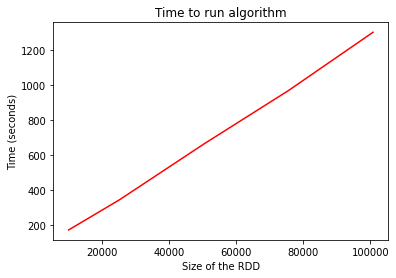

In [ ]:
plt.plot([N*size for size in sizes], durations, 'r-')
plt.title("Time to run algorithm")
plt.xlabel("Size of the RDD")
plt.ylabel("Time (seconds)")

**Toivonen Algorithm** 

In [ ]:
# thresholds tested = 0.006, 0.0075, 0.01, 0.03

threshold = 0.006


In [ ]:
N

100833

In [ ]:
# sample p% baskets (bags-of-words)
# change p here to use different sampling percentages eg.: 5%, 10%, 15%

p = 0.1

sampled_data = text_tokenized.sample(withReplacement = False, fraction = p, seed = 1997) \
                           .collect()

# define a threshold slightly lower than the global one
local_threshold = 0.999*threshold  

In [ ]:
# use built-in A-Priori as algorithm
! pip install apyori

from apyori import apriori

  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5974 sha256=1b549b0d558c0defa069bddec48fa566c7b8cd1897651bf08a915b649169633d
  Stored in directory: /root/.cache/pip/wheels/cb/f6/e1/57973c631d27efd1a2f375bd6a83b2a616c4021f24aab84080
Successfully built apyori


In [ ]:
sample_freq_itemsets = list(apriori(sampled_data, min_support = local_threshold))
sample_freq_itemsets =[list(sample_freq_itemsets[i][0]) for i in range(0,len(sample_freq_itemsets))]


In [ ]:
sample_freq_itemsets

[['according'],
 ['ago'],
 ['along'],
 ['also'],
 ['always'],
 ['american'],
 ['among'],
 ['another'],
 ['area'],
 ['around'],
 ['asked'],
 ['away'],
 ['back'],
 ['best'],
 ['better'],
 ['big'],
 ['bill'],
 ['board'],
 ['building'],
 ['business'],
 ['call'],
 ['called'],
 ['came'],
 ['car'],
 ['case'],
 ['center'],
 ['change'],
 ['child'],
 ['city'],
 ['cleveland'],
 ['coach'],
 ['college'],
 ['come'],
 ['community'],
 ['company'],
 ['cost'],
 ['could'],
 ['country'],
 ['county'],
 ['course'],
 ['court'],
 ['cut'],
 ['day'],
 ['deal'],
 ['decision'],
 ['department'],
 ['director'],
 ['district'],
 ['done'],
 ['early'],
 ['end'],
 ['enough'],
 ['even'],
 ['event'],
 ['every'],
 ['face'],
 ['family'],
 ['fan'],
 ['far'],
 ['federal'],
 ['feel'],
 ['field'],
 ['find'],
 ['first'],
 ['five'],
 ['foot'],
 ['former'],
 ['found'],
 ['four'],
 ['free'],
 ['friday'],
 ['friend'],
 ['game'],
 ['get'],
 ['getting'],
 ['give'],
 ['go'],
 ['going'],
 ['good'],
 ['got'],
 ['government'],
 ['great'],

In [ ]:
# build the negative border by finding all itemsets that are not frequent in the sample,
# but whose immediate subsets are frequent in it
# we can use the already defined function find_candidate_itemsets

k = 1
nb = []
freq_k_itemsets = list(filter(lambda x: len(x) == 1, sample_freq_itemsets))
checklist = list(map(set, sample_freq_itemsets))

while len(freq_k_itemsets) > 0:
  
  nb_candidates = find_candidate_itemsets(freq_k_itemsets, k+1)
  checklist_k1 = list(filter(lambda x: len(x) == k+1, checklist))
  nb_candidates = list(filter(lambda x: x not in checklist, nb_candidates))
  nb += nb_candidates

  k += 1
  freq_k_itemsets = list(filter(lambda x: len(x) == k, sample_freq_itemsets))

In [ ]:
 len(nb) #0.1


31354

In [ ]:
nb #0.1

[{'according', 'ago'},
 {'according', 'along'},
 {'according', 'also'},
 {'according', 'always'},
 {'according', 'american'},
 {'according', 'among'},
 {'according', 'another'},
 {'according', 'area'},
 {'according', 'around'},
 {'according', 'asked'},
 {'according', 'away'},
 {'according', 'back'},
 {'according', 'best'},
 {'according', 'better'},
 {'according', 'big'},
 {'according', 'bill'},
 {'according', 'board'},
 {'according', 'building'},
 {'according', 'business'},
 {'according', 'call'},
 {'according', 'called'},
 {'according', 'came'},
 {'according', 'car'},
 {'according', 'case'},
 {'according', 'center'},
 {'according', 'change'},
 {'according', 'child'},
 {'according', 'city'},
 {'according', 'cleveland'},
 {'according', 'coach'},
 {'according', 'college'},
 {'according', 'come'},
 {'according', 'community'},
 {'according', 'company'},
 {'according', 'cost'},
 {'according', 'could'},
 {'according', 'country'},
 {'according', 'county'},
 {'according', 'course'},
 {'accordi

In [ ]:
# verifying if the items belonging to the negative border are frequent in the eng_tokenized
trial = text_tokenized.flatMap(lambda bow: [(tuple(c), 1) for c in nb if c.issubset(set(bow))]) \
                     .reduceByKey(sumcum) \
                     .filter(lambda t: t[1] >= threshold*N) \
                     .collect()

# to complete the algorithm, we would need to restart from the sampling if the condition len(trial) > 0 is satisfied

In [ ]:
trial #0.1

[(('two', 'said'), 1010), (('good', 'said'), 1015)]

In [ ]:
len(trial) #0.01

2

In [ ]:
trial1 #0.0075

[]

In [ ]:
trial2 #0.006

p=0.05 no results,t=0.03 same